In [48]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.utils import shuffle
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

In [49]:
def initialize_s_i(X, n_components, random_state=None):
    # Initialization code remains unchanged.
    n_samples, n_features = X.shape
    if random_state is not None:
        np.random.seed(random_state)
    gamma = np.random.rand(n_samples, n_components)
    gamma /= gamma.sum(axis=1, keepdims=True)
    gamma_x = gamma[:, :, np.newaxis] * X[:, np.newaxis, :]
    gamma_xx = np.empty((n_samples, n_components, n_features, n_features))
    for i in range(n_samples):
        for k in range(n_components):
            x = X[i]
            gamma_xx[i, k] = gamma[i, k] * np.outer(x, x)
    return gamma, gamma_x, gamma_xx

def compute_responsibilities(x_i, pi, mu_k, sigma_k):
    n_components = len(pi)
    probs = np.zeros(n_components)
    for k in range(n_components):
        probs[k] = pi[k] * multivariate_normal.pdf(x_i, mean=mu_k[k], cov=sigma_k[k])
    return probs

def compute_parameters(mu, n_samples):
    pi = mu['N'] / n_samples
    mu_k = mu['sum_x'] / mu['N'][:, np.newaxis]
    n_components, n_features = mu_k.shape
    sigma_k = np.empty((n_components, n_features, n_features))
    for k in range(n_components):
        sigma_k[k] = mu['sum_xx'][k] / mu['N'][k] - np.outer(mu_k[k], mu_k[k])
    return pi, mu_k, sigma_k

def online_stepwise_em_gmm(X, n_components, T, alpha=0.6, random_state=None):
    n_samples, n_features = X.shape
    if random_state is not None:
        np.random.seed(random_state)
    
    # Initialize parameters
    gamma, gamma_x, gamma_xx = initialize_s_i(X, n_components, random_state)
    mu = {
        'N': gamma.sum(axis=0),
        'sum_x': gamma_x.sum(axis=0),
        'sum_xx': gamma_xx.sum(axis=0)
    }
    
    k = 0  # Step counter
    
    # EM iterations
    for t in range(T):
        X, indices = shuffle(X, np.arange(n_samples), random_state=random_state)
        for i in indices:
            x_i = X[i]

            pi, mu_k, sigma_k = compute_parameters(mu, n_samples)
            
            # Compute responsibilities for data point x_i
            probs = compute_responsibilities(x_i, pi, mu_k, sigma_k)
            gamma_prime = probs / probs.sum()
            
            # Compute new sufficient statistics s'_i
            s_prime_i_gamma = gamma_prime
            s_prime_i_gamma_x = gamma_prime[:, np.newaxis] * x_i
            s_prime_i_gamma_xx = np.array([gamma_prime[k] * np.outer(x_i, x_i) for k in range(n_components)])
            
            # Update stepsize
            eta_k = (k + 2) ** -alpha
            
            # Update global sufficient statistics μ
            mu['N'] = (1 - eta_k) * mu['N'] + eta_k * s_prime_i_gamma
            mu['sum_x'] = (1 - eta_k) * mu['sum_x'] + eta_k * s_prime_i_gamma_x
            mu['sum_xx'] = (1 - eta_k) * mu['sum_xx'] + eta_k * s_prime_i_gamma_xx
            
            k += 1
    
    # Compute final parameters
    pi, mu_k, sigma_k = compute_parameters(mu, n_samples)
    return pi, mu_k, sigma_k



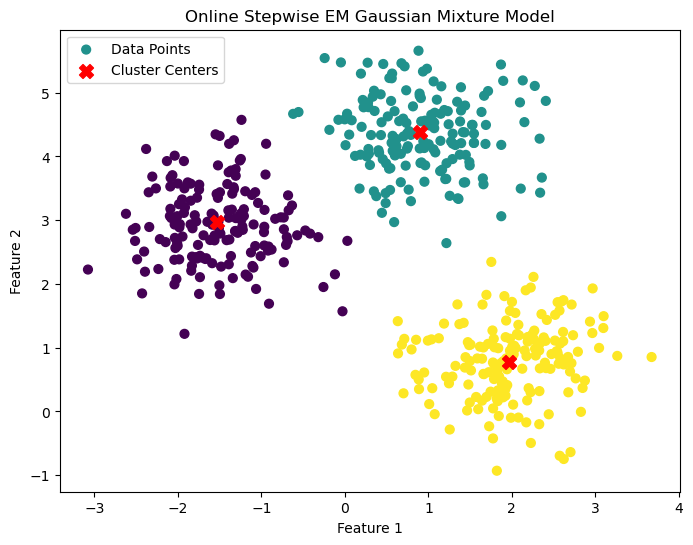

In [ ]:

# # Example usage
# if __name__ == "__main__":
#     X, y_true = make_blobs(n_samples=500, centers=3, cluster_std=0.60, random_state=0)
#     n_components = 3
#     T = 10  # Number of iterations
#     alpha = 0.6  # Stepwise parameter
#     random_state = 42
    
#     pi, mu_k, sigma_k = online_stepwise_em_gmm(X, n_components=n_components, T=T, alpha=alpha, random_state=random_state)
    
#     # Assign clusters and plot results
#     labels = np.zeros(X.shape[0], dtype=int)
#     for i in range(X.shape[0]):
#         x_i = X[i]
#         probs = compute_responsibilities(x_i, pi, mu_k, sigma_k)
#         labels[i] = np.argmax(probs)
    
#     plt.figure(figsize=(8, 6))
#     plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', label='Data Points')
#     plt.scatter(mu_k[:, 0], mu_k[:, 1], c='red', s=100, marker='X', label='Cluster Centers')
#     plt.title('Online Stepwise EM Gaussian Mixture Model')
#     plt.xlabel('Feature 1')
#     plt.ylabel('Feature 2')
#     plt.legend()
#     plt.show()

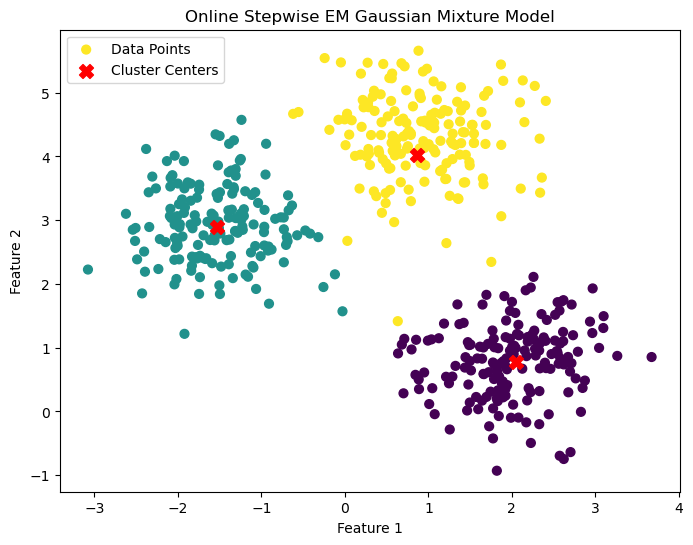

In [15]:
def initialize_s_i(n_components, n_features, random_state=None):
    # Random initialization without seeing the entire dataset
    if random_state is not None:
        np.random.seed(random_state)
    
    # Initialize gamma, gamma_x, gamma_xx randomly
    gamma = np.random.rand(n_components)
    gamma /= gamma.sum()  # Normalize to sum to 1
    gamma_x = np.random.rand(n_components, n_features)
    gamma_xx = np.array([np.eye(n_features) for _ in range(n_components)])  # Initialize as identity matrices to ensure positive semidefiniteness
    
    return gamma, gamma_x, gamma_xx

def compute_responsibilities(x_i, pi, mu_k, sigma_k):
    n_components = len(pi)
    probs = np.zeros(n_components)
    for k in range(n_components):
        probs[k] = pi[k] * multivariate_normal.pdf(x_i, mean=mu_k[k], cov=sigma_k[k])
    return probs

def compute_parameters(mu, n_samples):
    pi = mu['N'] / n_samples
    mu_k = mu['sum_x'] / mu['N'][:, np.newaxis]
    n_components, n_features = mu_k.shape
    sigma_k = np.empty((n_components, n_features, n_features))
    for k in range(n_components):
        sigma_k[k] = mu['sum_xx'][k] / mu['N'][k] - np.outer(mu_k[k], mu_k[k])
        # Ensure sigma_k is positive semidefinite
        sigma_k[k] = (sigma_k[k] + sigma_k[k].T) / 2  # Symmetrize
        eigvals, eigvecs = np.linalg.eigh(sigma_k[k])
        eigvals[eigvals < 1e-6] = 1e-6  # Clip eigenvalues to ensure positive semidefiniteness
        sigma_k[k] = eigvecs @ np.diag(eigvals) @ eigvecs.T
    return pi, mu_k, sigma_k

def online_stepwise_em_gmm(X, n_components, T, alpha=0.6, random_state=None):
    n_samples, n_features = X.shape
    if random_state is not None:
        np.random.seed(random_state)
    
    # Initialize parameters
    gamma, gamma_x, gamma_xx = initialize_s_i(n_components, n_features, random_state)
    mu = {
        'N': gamma,
        'sum_x': gamma_x,
        'sum_xx': gamma_xx
    }
    
    k = 0  # Step counter
    
    # EM iterations
    for t in range(T):
        X, indices = shuffle(X, np.arange(n_samples), random_state=random_state)
        for i in indices:
            x_i = X[i]
            
            # Compute responsibilities for data point x_i
            probs = compute_responsibilities(x_i, mu['N'] / n_samples, mu['sum_x'] / mu['N'][:, np.newaxis], mu['sum_xx'] / mu['N'][:, np.newaxis, np.newaxis])
            gamma_prime = probs / probs.sum()
            
            # Compute new sufficient statistics s'_i
            s_prime_i_gamma = gamma_prime
            s_prime_i_gamma_x = gamma_prime[:, np.newaxis] * x_i
            s_prime_i_gamma_xx = np.array([gamma_prime[k] * np.outer(x_i, x_i) for k in range(n_components)])
            
            # Update stepsize
            eta_k = (k + 2) ** -alpha
            
            # Update global sufficient statistics μ
            mu['N'] = (1 - eta_k) * mu['N'] + eta_k * s_prime_i_gamma
            mu['sum_x'] = (1 - eta_k) * mu['sum_x'] + eta_k * s_prime_i_gamma_x
            mu['sum_xx'] = (1 - eta_k) * mu['sum_xx'] + eta_k * s_prime_i_gamma_xx
            
            k += 1
    
    # Compute final parameters
    pi, mu_k, sigma_k = compute_parameters(mu, n_samples)
    return pi, mu_k, sigma_k

# Example usage
if __name__ == "__main__":
    X, y_true = make_blobs(n_samples=500, centers=3, cluster_std=0.60, random_state=0)
    n_components = 3
    T = 15  # Number of iterations
    alpha = 0.7  # Stepwise parameter
    random_state = 42
    
    pi, mu_k, sigma_k = online_stepwise_em_gmm(X, n_components=n_components, T=T, alpha=alpha, random_state=random_state)
    
    # Assign clusters and plot results
    labels = np.zeros(X.shape[0], dtype=int)
    for i in range(X.shape[0]):
        x_i = X[i]
        probs = compute_responsibilities(x_i, pi, mu_k, sigma_k)
        labels[i] = np.argmax(probs)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', label='Data Points')
    plt.scatter(mu_k[:, 0], mu_k[:, 1], c='red', s=100, marker='X', label='Cluster Centers')
    plt.title('Online Stepwise EM Gaussian Mixture Model')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()


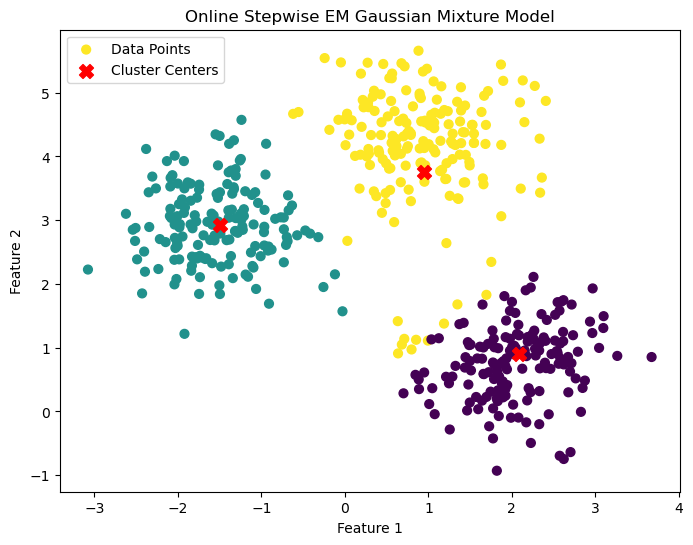

In [29]:
# Larger dataset?

def initialize_s_i(n_components, n_features, random_state=None):
    # Random initialization without seeing the entire dataset
    if random_state is not None:
        np.random.seed(random_state)
    
    # Initialize gamma, gamma_x, gamma_xx randomly
    gamma = np.random.rand(n_components)
    gamma /= gamma.sum()  # Normalize to sum to 1
    gamma_x = np.random.rand(n_components, n_features)
    gamma_xx = np.array([np.eye(n_features) for _ in range(n_components)])  # Initialize as identity matrices to ensure positive semidefiniteness
    
    return gamma, gamma_x, gamma_xx

def compute_responsibilities(x_i, pi, mu_k, sigma_k):
    n_components = len(pi)
    probs = np.zeros(n_components)
    for k in range(n_components):
        probs[k] = pi[k] * multivariate_normal.pdf(x_i, mean=mu_k[k], cov=sigma_k[k])
    return probs

def compute_parameters(mu, n_samples):
    pi = mu['N']
    mu_k = mu['sum_x'] / mu['N'][:, np.newaxis]
    n_components, n_features = mu_k.shape
    sigma_k = np.empty((n_components, n_features, n_features))
    for k in range(n_components):
        sigma_k[k] = mu['sum_xx'][k] / mu['N'][k] - np.outer(mu_k[k], mu_k[k])
        # Ensure sigma_k is positive semidefinite
        sigma_k[k] = (sigma_k[k] + sigma_k[k].T) / 2  # Symmetrize
        eigvals, eigvecs = np.linalg.eigh(sigma_k[k])
        eigvals[eigvals < 1e-6] = 1e-6  # Clip eigenvalues to ensure positive semidefiniteness
        sigma_k[k] = eigvecs @ np.diag(eigvals) @ eigvecs.T
    return pi, mu_k, sigma_k

def online_stepwise_em_gmm(X, n_components, T, alpha=0.6, random_state=None):
    n_samples, n_features = X.shape
    if random_state is not None:
        np.random.seed(random_state)
    
    # Initialize parameters
    gamma, gamma_x, gamma_xx = initialize_s_i(n_components, n_features, random_state)
    mu = {
        'N': gamma,
        'sum_x': gamma_x,
        'sum_xx': gamma_xx
    }
    
    k = 0  # Step counter
    
    # EM iterations
    for t in range(T):

        X, indices = shuffle(X, np.arange(n_samples), random_state=random_state)

        for i in indices:
            x_i = X[i]
            
            # Compute responsibilities for data point x_i
            probs = compute_responsibilities(x_i, mu['N'], mu['sum_x'] / mu['N'][:, np.newaxis], mu['sum_xx'] / mu['N'][:, np.newaxis, np.newaxis])
            gamma_prime = probs / probs.sum()
            
            # Compute new sufficient statistics s'_i
            s_prime_i_gamma = gamma_prime
            s_prime_i_gamma_x = gamma_prime[:, np.newaxis] * x_i
            s_prime_i_gamma_xx = np.array([gamma_prime[k] * np.outer(x_i, x_i) for k in range(n_components)])
            
            # Update stepsize
            eta_k = (k + 2) ** -alpha
            
            # Update global sufficient statistics μ
            mu['N'] = (1 - eta_k) * mu['N'] + eta_k * s_prime_i_gamma
            mu['sum_x'] = (1 - eta_k) * mu['sum_x'] + eta_k * s_prime_i_gamma_x
            mu['sum_xx'] = (1 - eta_k) * mu['sum_xx'] + eta_k * s_prime_i_gamma_xx
            
            k += 1
    
    # Compute final parameters
    pi, mu_k, sigma_k = compute_parameters(mu, n_samples)
    return pi, mu_k, sigma_k

# Example usage
if __name__ == "__main__":
    X, y_true = make_blobs(n_samples=500, centers=3, cluster_std=0.60, random_state=0)
    n_components = 3
    T = 1  # Number of iterations
    alpha = 0.7  # Stepwise parameter
    random_state = 42
    
    pi, mu_k, sigma_k = online_stepwise_em_gmm(X, n_components=n_components, T=T, alpha=alpha, random_state=random_state)
    
    # Assign clusters and plot results
    labels = np.zeros(X.shape[0], dtype=int)
    for i in range(X.shape[0]):
        x_i = X[i]
        probs = compute_responsibilities(x_i, pi, mu_k, sigma_k)
        labels[i] = np.argmax(probs)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', label='Data Points')
    plt.scatter(mu_k[:, 0], mu_k[:, 1], c='red', s=100, marker='X', label='Cluster Centers')
    plt.title('Online Stepwise EM Gaussian Mixture Model')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()
